In [110]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib            
print (matplotlib.rcParams['backend'])
%matplotlib --list


inline
Available matplotlib backends: ['agg', 'auto', 'cairo', 'gtk3', 'gtk3agg', 'gtk3cairo', 'gtk4', 'gtk4agg', 'gtk4cairo', 'inline', 'macosx', 'module://matplotlib_inline.backend_inline', 'nbagg', 'notebook', 'osx', 'pdf', 'pgf', 'ps', 'qt', 'qt5', 'qt5agg', 'qt5cairo', 'qt6', 'qtagg', 'qtcairo', 'svg', 'template', 'tk', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wx', 'wxagg', 'wxcairo']


In [111]:
def f(x):
    return 3*x**2 - 4 * x +5


In [112]:
f(3.0)


20.0

In [113]:
xs = np.arange(-5,5,0.25)


In [114]:
xs


array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [115]:
ys = f(xs)


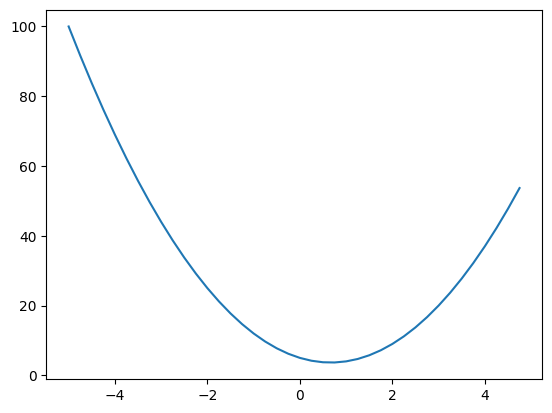

In [116]:
plt.plot(xs,ys)
plt.show()

In [117]:
h = 0.001
x = -3.0
(f(x+h)-f(x))/h

-21.996999999998934

In [118]:
#let's get a little more complex
a=2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [119]:
h = 0.0001

#inputs

a = 2.0
b = -3.0 
c = 10.0

d1 = a*b + c
c+=h
d2 = a*b + c

print('d1', d1)
print('d2',d2)

print('slope', (d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [120]:
#as we mentioned neural networks will be pretty massive expressions

In [121]:
#we will need data structures that can hold this structure

In [337]:
#you define operators for objects in python using a double underscore variable
class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 #at initialization, we are assuming every value does not effect the output value
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"value(data={self.data})"
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value (other)
        out = Value(self.data+other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += (other.data* out.grad)
            other.grad += (self.data * out.grad)
        out._backward = _backward
        
        return out
    def __rmul__(self,other): # other * self
        return self * other
    
    def __sub__(self, other): #self - other
        return self +(-other)
    def __radd__(self,other): #other + self
        return self + other
    
    def __neg__(self): #-self
        return self*-1
    def __truediv__(self, other): # self / other
        return self * other**-1
        
    def __pow__(self,other):
        assert isinstance(other,(int, float)) ,"only supporting ints and floats"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad+=other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) /(math.exp(2*x)+1)
        out = Value(t,(self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self, ), 'exp')
        def _backward():
            self.grad += (out.data * out.grad)
            out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
         node._backward()


        




In [123]:
from graphviz import Digraph

        

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid,label = "{%s| data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
    # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

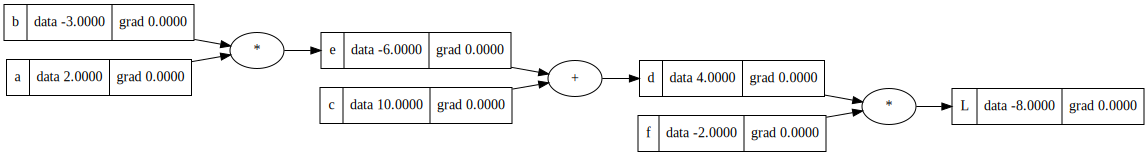

In [124]:
draw_dot(L)

In [125]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c 
L = d*f

print(L.data)


-8.0


In [126]:
def lol(): 
    #this is a gating function so as to not pollute the global scope
    h = 0.001
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e' #here we set the value of e and its label
    d = e + c; d.label = 'd' #python will internally call a.__add__(b)
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label = 'a') #this will be measuring the derivative of L with respect to a
    b = Value(-3.0, label = 'b')
    b.data +=h
    c = Value(10.0, label = 'c')
    
    e = a*b; e.label = 'e' #here we set the value of e and its label
    d = e + c; d.label = 'd' #python will internally call a.__add__(b)
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L2 = L.data
    print((L2 - L1)/h) 
    
lol()

-3.9999999999995595


In [127]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2))); 

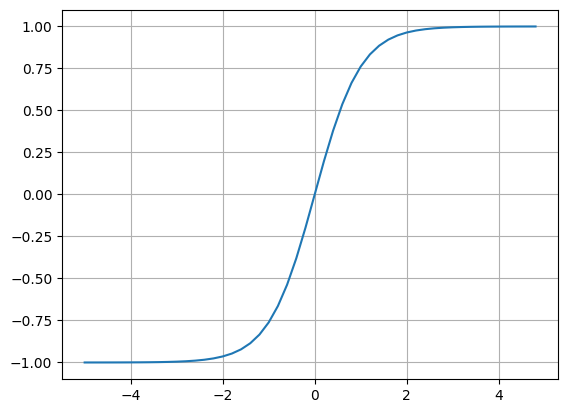

In [128]:
plt.grid();

plt.show();

In [289]:
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')


#bias of the neuron
b = Value(6.8813735870195432, label = 'b')

#x1*w1 + x2*w2 +bß
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#tanh h is an exponentiation function, so we need to include exponentials. 
o = n.tanh(); o.label = 'o'

o.backward()


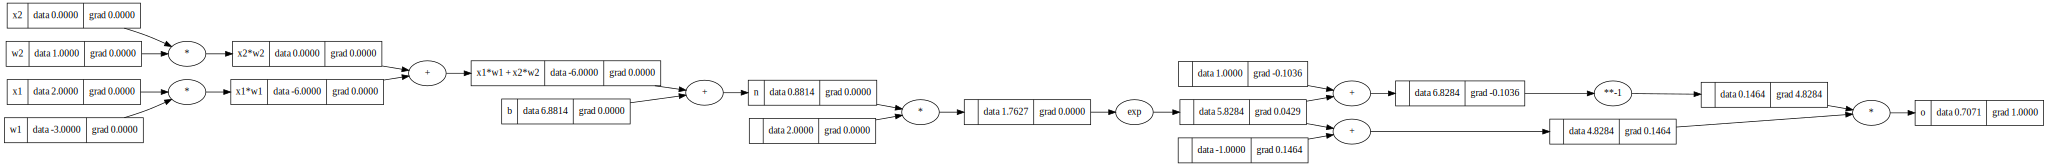

In [297]:
draw_dot(o)

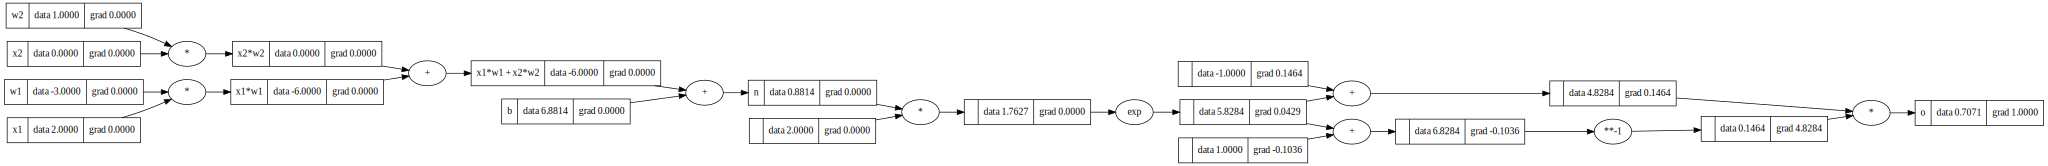

In [338]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)


In [280]:
a = Value(2.0)
b = Value(4.0)

a - b 

value(data=-2.0)